In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

def show_amazonas(imagen_RGB):
    """
    Muestra la imagen RGB compuesta de la Amazonía con zoom progresivo desde una coordenada inicial.

    Args:
        imagen_RGB (ndarray): Imagen RGB compuesta.
        x0 (int): Coordenada inicial en el eje x.
        y0 (int): Coordenada inicial en el eje y.
    """
    niveles_zoom = [
        {"tamaño": 3000, "x0": 2000, "y0": 2000},  # Nivel 1: Recorte amplio
        {"tamaño": 1000, "x0": 3000, "y0": 3000},  # Nivel 2: Recorte medio
        {"tamaño": 500, "x0": 3000, "y0": 3250}    # Nivel 3: Recorte detallado
    ]

    plt.figure(figsize=(15, 15))
    for i, zoom in enumerate(niveles_zoom, start=1):
        tamaño = zoom["tamaño"]
        x1 = zoom["x0"] + tamaño
        y1 = zoom["y0"] + tamaño
        x1 = min(x1, imagen_RGB.shape[1])
        y1 = min(y1, imagen_RGB.shape[0])

        recorte = imagen_RGB[zoom["y0"]:y1, zoom["x0"]:x1]

        plt.subplot(1, 3, i)
        plt.imshow(recorte, origin='upper')
        plt.axis('off')
        plt.title(f"Zoom Nivel {i} ({tamaño}x{tamaño})", fontsize=14)

    plt.tight_layout()
    plt.show()

def calibrate_imag(imagen, metadato, U='T'):
    """
    Calibra la imagen basada en los metadatos de GOES-16.

    Args:
        imagen (ndarray): Datos de la imagen sin procesar.
        metadato (dict): Metadatos asociados con la imagen.
        U (str): Unidad de salida ('T' para temperatura, 'Rad' para radiancia, 'Ref' para reflectancia).

    Returns:
        ndarray: Imagen calibrada.
    """
    canal = int(metadato['band_id'][:])
    if canal >= 7 and U == 'T':
        # Calibración a temperatura de brillo
        fk1 = metadato['planck_fk1'][0]
        fk2 = metadato['planck_fk2'][0]
        bc1 = metadato['planck_bc1'][0]
        bc2 = metadato['planck_bc2'][0]

        imagen = np.where(imagen > 0, imagen, np.nan) 
        imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1) / bc2 - 273.15 
    elif U == 'Rad':
        # Calibración a radiancia
        pendiente = metadato['Rad'].scale_factor
        ordenada = metadato['Rad'].add_offset
        imag_cal = imagen * pendiente + ordenada
    elif U == 'Ref':
        # Calibración a reflectancia
        kapa0 = metadato['kappa0'][0].data
        imag_cal = kapa0 * imagen
    else:
        raise ValueError(f"Unidad de calibración '{U}' no reconocida. Use 'T', 'Rad' o 'Ref'.")

    return imag_cal


def realce_gama(V, A, gamma, Vmin, Vmax):
    """
    Aplica el realce de gamma a una imagen o matriz de datos.

    Args:
        V (ndarray): Matriz de datos de entrada.
        A (float): Amplitud de salida.
        gamma (float): Exponente de gamma para el realce.
        Vmin (float): Valor mínimo para la normalización.
        Vmax (float): Valor máximo para la normalización.

    Returns:
        ndarray: Matriz con el realce de gamma aplicado.
    """
    Vaux = np.clip((V - Vmin) / (Vmax - Vmin), 0, 1)
    Vout = A * Vaux**gamma
    return Vout

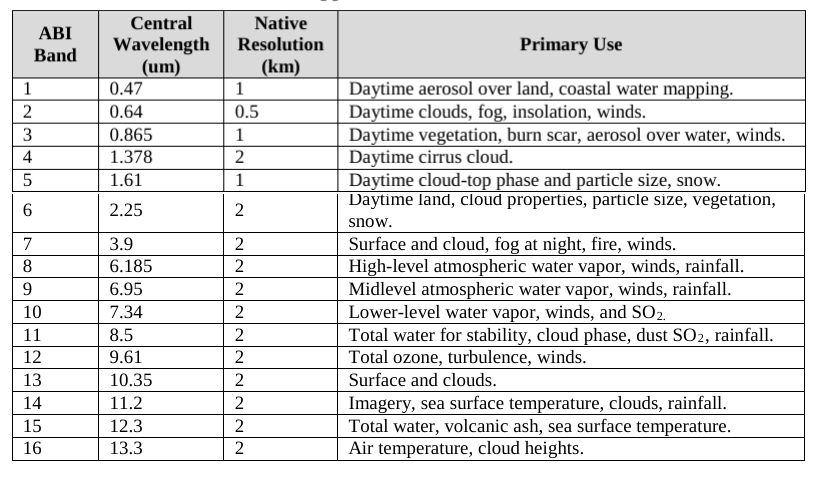

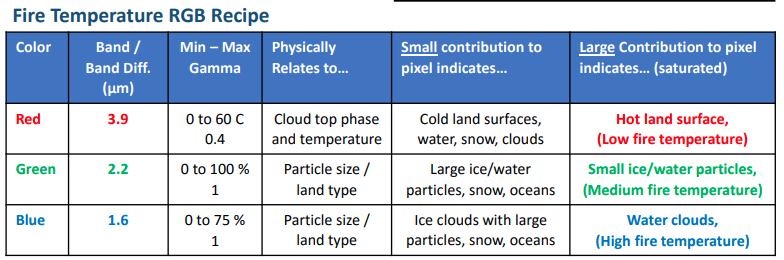

In [3]:
# Fire temperature RGB
dir_img = '../goes_fire'
image_list = sorted(os.listdir(dir_img))
images = [Dataset(os.path.join(dir_img, filename)) for filename in image_list]
metadato5 = images[0].variables
metadato6 = images[1].variables
metadato7 = images[2].variables

imagen5=metadato5['Rad'][::2,::2].data
imagen6=metadato6['Rad'][:].data
imagen7=metadato7['Rad'][:].data

imag_calibrate5 = calibrate_imag(imagen5, metadato5, 'Ref')
imag_calibrate6 = calibrate_imag(imagen6, metadato6, 'Ref')
imag_calibrate7  = calibrate_imag(imagen7, metadato7, 'T')

[filas,columnas] = imag_calibrate5.shape
imagen_RGB_fire= np.zeros([filas,columnas,3])
red_imagen = imag_calibrate7
green_imagen = imag_calibrate6
blue_imagen = imag_calibrate5
realce_red = realce_gama(red_imagen, 1, 2.5, 0, 60)
# Tuve que cambiar el valor de gamma dado en la receta por 1/0.4 = 2.5 ya que no coincidia con nuestra formula
realce_green = realce_gama(green_imagen,1, 1, 0, 1)
realce_blue = realce_gama(blue_imagen, 1, 1, 0, 0.75)

imagen_RGB_fire[:,:,0] = realce_red
imagen_RGB_fire[:,:,1] = realce_green
imagen_RGB_fire[:,:,2] = realce_blue

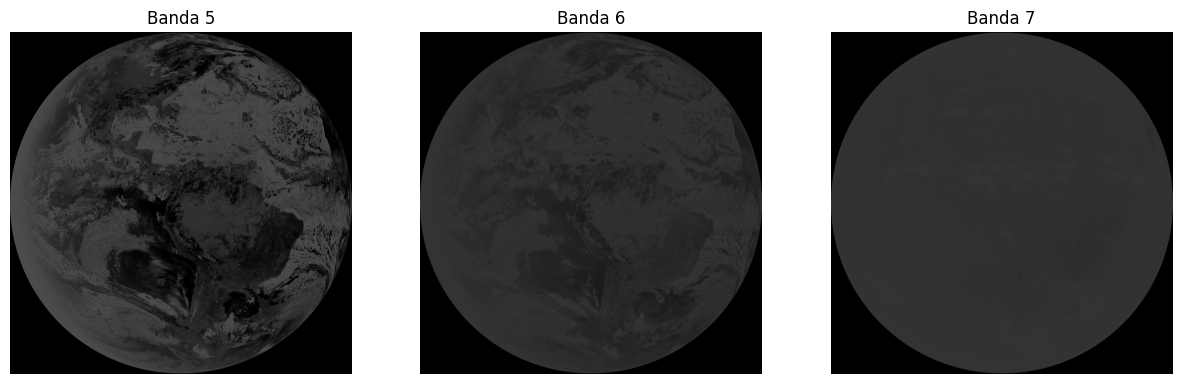

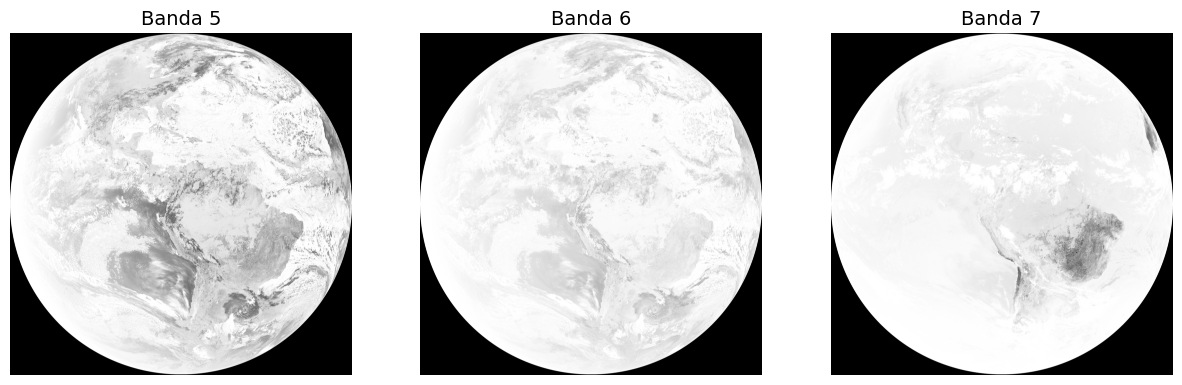

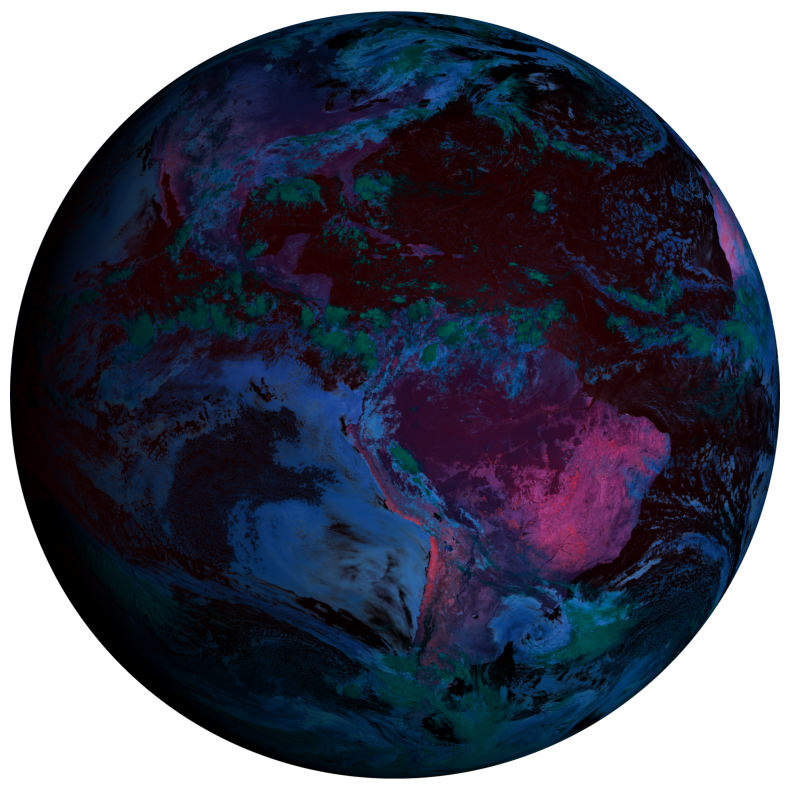

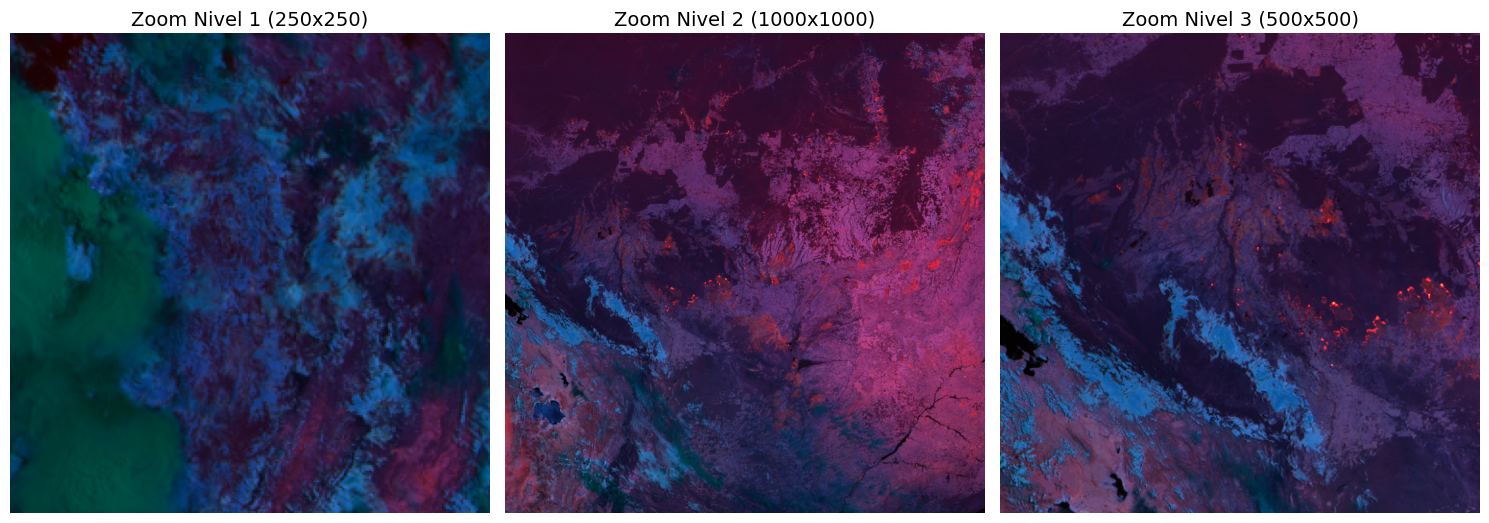

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imagen5, vmin=-100, vmax=30, cmap='Greys')
plt.axis('off')
plt.title('Banda 5')
plt.subplot(1, 3, 2)
plt.imshow(imagen6, vmin=-100, vmax=20, cmap='Greys')
plt.axis('off')
plt.title('Banda 6')
plt.subplot(1, 3, 3)
plt.imshow(imagen7, vmin=-100, vmax=20, cmap='Greys')
plt.axis('off')
plt.title('Banda 7')
plt.show()

#Plot calibrated and gamma corrected bands
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(realce_blue, cmap='Greys')
plt.axis('off')
plt.title('Banda 5', fontsize=14)
plt.subplot(1, 3, 2)
plt.imshow(realce_green, cmap='Greys')
plt.axis('off')
plt.title('Banda 6', fontsize=14)
plt.subplot(1, 3, 3)
plt.imshow(realce_red, cmap='Greys')
plt.axis('off')
plt.title('Banda 7', fontsize=14)

#Plot RGB image
plt.figure(figsize=(10, 10))
plt.imshow(imagen_RGB_fire)
plt.axis('off')
plt.show()

show_amazonas(imagen_RGB_fire)

In [ ]:
#VER VIDEO FULL DAY FIRE TEMP

In [6]:
# Cargar las bandas necesarias
dir_img = '../goes_true_color'
image_list = sorted(os.listdir(dir_img))
images = [Dataset(os.path.join(dir_img, filename)) for filename in image_list]
metadato1 = images[0].variables
metadato2 = images[1].variables
metadato3 = images[2].variables
imagen1 = metadato1['Rad'][::2,::2].data
imagen2 = metadato2['Rad'][::4,::4].data
imagen3 = metadato3['Rad'][::2,::2].data

imag_calibrate1 = calibrate_imag(imagen1, metadato1, 'Ref')  # Azul
imag_calibrate2 = calibrate_imag(imagen2, metadato2, 'Ref')  # Rojo
imag_calibrate3 = calibrate_imag(imagen3, metadato3, 'Ref')  # Verde
# Crear imagen RGB
[filas, columnas] = imag_calibrate1.shape
imagen_RGB_true_color = np.zeros((filas, columnas, 3))

# Asignar bandas con ajuste gamma
realce_red = realce_gama(imag_calibrate2, 1, 1, 0, 1)
realce_green = realce_gama(imag_calibrate3, 1, 1, 0, 1)
realce_blue = realce_gama(imag_calibrate1, 1, 1, 0, 1)

imagen_RGB_true_color[:, :, 0] = realce_red
imagen_RGB_true_color[:, :, 1] =  0.1 * realce_green + 0.45 * realce_red + 0.45 * realce_blue
imagen_RGB_true_color[:, :, 2] = realce_blue

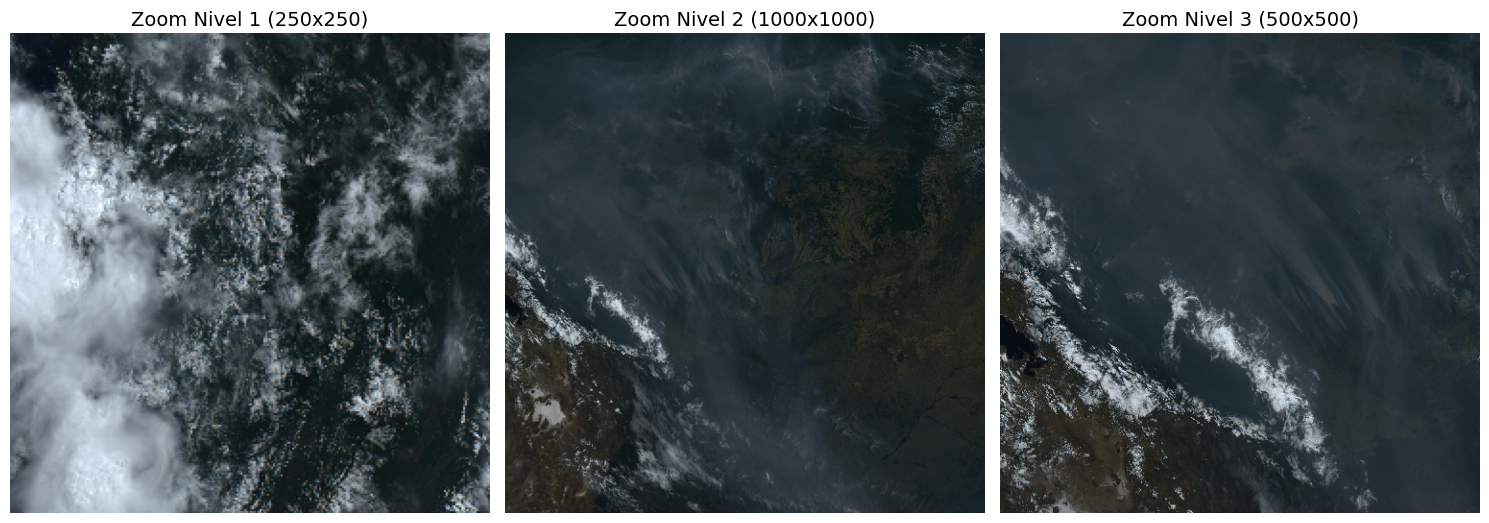

In [7]:
show_amazonas(imagen_RGB_true_color)

In [ ]:
#VER VIDEO FULL DAY TRUE COLOR